In [1]:
import torch
import torch.nn as nn
from torch.autograd.functional import hessian
import numpy as np
import matplotlib.pyplot as plt
import importlib
import mymodule
from functorch import make_functional, vmap, grad, jacrev
import functools
from scipy.optimize import brentq
from pyDOE import lhs

from collections import OrderedDict

import warnings
warnings.filterwarnings('ignore')

importlib.reload(mymodule)


<module 'mymodule' from '/Users/yimingren/Downloads/DCSNN-main/python/mymodule.cpython-38-darwin.so'>

In [2]:
torch.cuda.empty_cache()
torch.set_default_dtype(torch.float64)
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print('device = ', device)

device =  cpu


In [3]:
class Plain(nn.Module):
    
    def __init__(self, in_dim , h_dim , out_dim):
        super().__init__()
        self.ln1 = nn.Linear( in_dim , h_dim )
        self.act1 =nn.Sigmoid()
        self.ln2 = nn.Linear( h_dim , out_dim , bias=False )
        
    def forward(self, x):
        out = self.ln1(x)
        out = self.act1(out)
        out = self.ln2(out)
        return out
    
def count_parameters(model, requires_grad = True):
    """Count trainable parameters for a nn.Module."""
    if requires_grad:
        return sum(p.numel() for p in model.parameters() if p.requires_grad)
    return sum(p.numel() for p in model.parameters())

In [4]:
def compute_loss_Res(func_params, X_ij, Rf_ij):

    def f(x, func_params):
        output = func_model(func_params, x)
        return output.squeeze(0)
    # print(X_inner)
    grad2_f = (jacrev(grad(f)))(X_ij, func_params)
    dudX2 = (torch.diagonal(grad2_f))
    
    laplace = (dudX2[0] + dudX2[1])
    
    loss_Res = laplace + Rf_ij
 

    return loss_Res.flatten()


def compute_Laplace(func_params, X_ij):

    def f(x, func_params):
        output = func_model(func_params, x)
        return output.squeeze(0)
    # print(X_inner)
    grad2_f = (jacrev(grad(f)))(X_ij, func_params)
    dudX2 = (torch.diagonal(grad2_f))
    
    laplace = (dudX2[0] + dudX2[1])
    
 

    return laplace.flatten()


def compute_loss_j(func_params, X_ij, Vj_ij):

    def f(x, func_params):
        output = func_model(func_params, x)
        return output.squeeze(0)
    
    X_ij=X_ij.reshape(len(X_ij), 1)

    ij_on = torch.cat((X_ij[0], X_ij[1]), 0)
    
   
    V_ij_pred = f(ij_on, func_params)
   
    loss_j = V_ij_pred + Vj_ij
        
    return loss_j.flatten()

def compute_loss_normal_jump(func_params, X_ij, Normal_ij, Vnj_ij):

    def f(x, func_params):
        output = func_model(func_params, x)
        return output.squeeze(0)
    
    X_ij=X_ij.reshape(len(X_ij), 1)
    # print('X_ij.size()',X_ij.size())
    # print('X_ij',X_ij[0].size())
    
    ij_on = torch.cat((X_ij[0], X_ij[1]), 0)
    # print('ij_on',ij_on)
   
    normal_x = Normal_ij[0]
    normal_y = Normal_ij[1]

    
    df_on = (grad(f))(ij_on, func_params)
    
    Normal_on = normal_x*df_on[0] + normal_y*df_on[1]
    
    normal_jump_pred = Normal_on

    loss_normal_jump = normal_jump_pred + Vnj_ij
        
    return loss_normal_jump.flatten()

def compute_first_jump(func_params, X_ij):

    def f(x, func_params):
        output = func_model(func_params, x)
        return output.squeeze(0)
    # df_on = (grad(f))(ij_on, func_params)
    grad_f=(grad(f))(X_ij, func_params)
    u_x = grad_f[0]  # ∂u/∂x
    u_y = grad_f[1]  # ∂u/∂y
    
    return u_x,u_y

def compute_second_jump(func_params, X_ij):
    def f(x, func_params):
        output = func_model(func_params, x)
        return output.squeeze(0)

    grad2_f=(jacrev(grad(f)))(X_ij, func_params)
    dudX2 = (torch.diagonal(grad2_f))
    u_xx = dudX2[0]  # ∂³u/∂x³
    u_yy = dudX2[1]  # ∂³u/∂y³
    
    return u_xx,u_yy
def compute_third_jump(func_params, X_ij):
    def f(x, func_params):
        output = func_model(func_params, x)
        return output.squeeze(0)
    # df_on = (grad(f))(ij_on, func_params)
    grad3_f=(jacrev(jacrev(grad(f))))(X_ij, func_params)
    u_xxx = grad3_f[0, 0, 0]  # ∂³u/∂x³
    u_yyy = grad3_f[1, 1, 1]  # ∂³u/∂y³

    return u_xxx,u_yyy

def compute_fourth_jump(func_params, X_ij):  
    def f(x, func_params):
        output = func_model(func_params, x)
        return output.squeeze(0)

    grad4_f=(jacrev(jacrev(jacrev(grad(f)))))(X_ij, func_params)
    u_xxxx = grad4_f[0, 0, 0, 0]  # ∂³u/∂x³
    u_yyyy = grad4_f[1, 1, 1, 1]  # ∂³u/∂y³
    
    #loss_third_order_jump = u_xxx + u_yyy+df3_ij
   # loss_third_order_jump = u_xxx#normal_x**3*u_xxx +3*normal_x**2*normal_y*u_xxy+3*normal_x*normal_y**2*u_xyy+normal_y**3*u_yyy+df3_ij
        
    return u_xxxx,u_yyyy

def compute_second_order_jump(func_params, X_ij):

    def f(x, func_params):
        output = func_model(func_params, x)
        return output.squeeze(0)
    # df_on = (grad(f))(ij_on, func_params)
    
 
    # df_on = (grad(f))(ij_on, func_params)
    grad2_f=(jacrev(grad(f)))(X_ij, func_params)
    dudX2 = (torch.diagonal(grad2_f))
    u_xx = dudX2[0]  # ∂³u/∂x³
    u_yy = dudX2[1]  # ∂³u/∂y³
    # u_xxy = grad3_f[0, 0, 1]  # ∂³u/∂x²∂y
    # u_xyy = grad3_f[1, 1, 0]  # ∂³u/∂y²∂x
    
    #loss_third_order_jump = u_xxx + u_yyy+df3_ij
    loss_second_order_jump = u_xx#normal_x**3*u_xxx +3*normal_x**2*normal_y*u_xxy+3*normal_x*normal_y**2*u_xyy+normal_y**3*u_yyy+df3_ij
        
    return loss_second_order_jump.flatten()

def compute_loss_Res_biharmonic(func_params, X_ij, Rf_ij):
    # Function to compute the output from the neural network
    def f(x, func_params):
        output = func_model(func_params, x)
        return output.squeeze(0)

    # Compute the second-order derivatives of the neural network output (Laplacian)
    grad2_f = (jacrev(grad(f)))(X_ij, func_params)
    dudX2 = torch.diagonal(grad2_f)
    

    
    # Compute second derivatives of Laplacian (fourth-order terms for the biharmonic equation)
    def laplacian(x, func_params):
        grad2_f = (jacrev(grad(f)))(x, func_params)
        dudX2 = torch.diagonal(grad2_f)
        return dudX2[0] + dudX2[1]

    grad4_f = (jacrev(grad(laplacian)))(X_ij, func_params)
    biharmonic_res = torch.diagonal(grad4_f).sum()  # u_xxxx + 2u_xxyy + u_yyyy
    
    # Residual for the biharmonic equation
    loss_Res = biharmonic_res + Rf_ij

    return loss_Res.flatten()



In [5]:
aa=0.5
bb=0.1
cc=5.0
a=9.0
dd=np.pi/3

In [6]:
# exact_u = exact solution
def exact_u(x, y, z):
    u1 = np.sin(a*x)*np.sin(a*y)
    un1 =np.exp(x)*np.cos(y)
    eu = u1*(1.0+z)/2.0 + un1*(1.0-z)/2.0
    return eu

# rhs_f = right hand side function
def rhs_f(x, y, z):
    f1 = -2.0*a**2*np.sin(a*x)*np.sin(a*y)
    # print('f1.shape', f1.shape)
    fn1 = 0.0*x
    rf = f1*(1.0+z)/2.0 + fn1*(1.0-z)/2.0
    # print('rf.shape', rf.shape)
    return rf

def biharmonic_u(x, y, z):
    f1 = 4.0*a**4*np.sin(a*x)*np.sin(a*y)
    fn1 = 0.0*x
    rf = f1*(1.0+z)/2.0 + fn1*(1.0-z)/2.0
    return rf

# normal_u = \nabla u \dot n, normal derivative of u, only defined on the interface
def normal_u(x, y, z):
    normal = normal_vector(x, y)
    normal_x = normal[:, 0:1]
    normal_y = normal[:, 1:2]
    u1x = a*np.cos(a*x)*np.sin(a*y)
    u1y = a*np.sin(a*x)*np.cos(a*y)
    u1 = normal_x*u1x + normal_y*u1y
    un1x = np.exp(x)*np.cos(y)
    un1y = - np.exp(x)*np.sin(y)
    un1 = normal_x*un1x + normal_y*un1y
    nu = u1*(1.0+z)/2.0 + un1*(1.0-z)/2.0
    return nu

def ux_gradient(x,y,z):
    u1 = a*np.cos(a*x)*np.sin(a*y)
    un1 = np.exp(x)*np.cos(y)
    eu = u1*(1.0+z)/2.0 + un1*(1.0-z)/2.0
    return eu

def uy_gradient(x,y,z):
    u1 = a*np.sin(a*x)*np.cos(a*y)
    un1 = -np.exp(x)*np.sin(y)
    eu = u1*(1.0+z)/2.0 + un1*(1.0-z)/2.0
    return eu

def get_angle(xo, yo, radi):
    PI = np.pi
    theta = np.zeros_like(xo)

    # Condition where radius is near zero
    near_zero_mask = np.abs(radi) < 1.0e-14
    theta[near_zero_mask] = 0.0

    # Condition where y is zero
    y_zero_mask = (yo == 0) & ~near_zero_mask
    theta[y_zero_mask] = np.where(xo[y_zero_mask] > 0, 0.0, PI)

    # Condition where y is positive
    y_positive_mask = (yo > 0) & ~near_zero_mask
    theta[y_positive_mask] = np.arccos(xo[y_positive_mask] / radi[y_positive_mask])

    # Condition where y is negative
    y_negative_mask = (yo < 0) & ~near_zero_mask
    theta[y_negative_mask] = 2.0 * PI - np.arccos(xo[y_negative_mask] / radi[y_negative_mask])

    return theta
# normal_vector = normal vector, only defined on the interface
def normal_vector(x, y):
    theta=get_angle(x, y, np.sqrt(x**2+y**2))
    dist=np.sqrt(aa**2+2.0*aa*bb*np.sin(cc*theta)+bb**2-bb**2*np.cos(cc*theta)**2+bb**2*cc**2*np.cos(cc*theta)**2)
    normal_x=(aa*np.cos(theta)+bb*np.cos(theta)*np.sin(cc*theta)+bb*cc*np.sin(theta)*np.cos(cc*theta))/dist
    normal_y=(aa*np.sin(theta)+bb*np.sin(theta)*np.sin(cc*theta)-bb*cc*np.cos(theta)*np.cos(cc*theta))/dist
    normal=np.hstack((normal_x, normal_y))
    return normal


def sign_x(x, y):
    z = 0.0*x + 1.0
 
    r=np.sqrt(x**2+y**2)
    theta=get_angle(x, y, r)
   

    # Create a mask for elements where the distance is less than 1.0
    mask = r-(aa+bb*np.sin(cc*theta))<=1.0e-12

    # Update z array where the mask is True
    z[mask] = -1.0
    return z

def df3(x, y):

    uxxx1 = -a**3*np.cos(a*x)*np.sin(a*y)
    uyyy1 = -a**3*np.sin(a*x)*np.cos(a*y)
   
    uxxxn1= np.exp(x)*np.cos(y)
    uyyyn1= np.exp(x)*np.sin(y)
    
    uxxx=uxxx1-uxxxn1
    uyyy=uyyy1-uyyyn1
    # rf = df31*(1.0+z)/2.0 + df3n1*(1.0-z)/2.0
    return uxxx, uyyy

def df2(x, y):
   
    uxx1 = -a**2*np.sin(a*x)*np.sin(a*y)
    uyy1 = -a**2*np.sin(a*x)*np.sin(a*y)
   
    uxxn1= np.exp(x)*np.cos(y)
    uyyn1= -np.exp(x)*np.cos(y)
   
    uxx=uxx1-uxxn1
    uyy=uyy1-uyyn1
   
    return uxx,uyy

def df4(x, y):
   
    uxxxn1 = a**4*np.sin(a*x)*np.sin(a*y)
    uyyyn1 = a**4*np.sin(a*x)*np.sin(a*y)
    
    uxxx1= np.exp(x)*np.cos(y)
    uyyy1= np.exp(x)*np.cos(y)
    
    uxxxx=uxxxn1-uxxx1
    uyyyy=uyyyn1-uyyy1

    return uxxxx, uyyyy


def df1(x, y):
    ux1 = a*np.cos(a*x)*np.sin(a*y)
    unx1 =np.exp(x)*np.cos(y)
    ux=ux1-unx1

    uy1 = a*np.sin(a*x)*np.cos(a*y)
    uny1 = -np.exp(x)*np.sin(y)
    uy=uy1-uny1
    return ux,uy

In [7]:


# # Function to round points to avoid floating-point precision issues when checking for duplicates
def round_point(x, y, precision=8):
    return (round(x, precision), round(y, precision))

def equation(theta, val, mode):
        if mode == 'x':
            return (aa + bb * np.sin(cc * theta)) * np.cos(theta) - val
        elif mode == 'y':
            return (aa + bb * np.sin(cc * theta)) * np.sin(theta) - val
        
def find_intersect_theta(y1,y2,x,mode):
        r1 = np.sqrt(x**2 + y1**2)
        r2 = np.sqrt(x**2 + y2**2)
        if mode == 'x':
            theta1 = get_angle(x, y1, r1)
            theta2 = get_angle(x, y2, r2)
        elif mode == 'y':
            theta1 = get_angle(y1, x, r1)
            theta2 = get_angle(y2, x, r2)
        if (theta2==0.0) and (abs(theta1-theta2)>np.pi):
            theta2=2*np.pi
        if np.isclose(theta1, theta2):
            theta_intersection = theta1
        else:
            # Solve nonlinear equation within the interval [theta1, theta2]
            theta_intersection = brentq(equation, theta1,theta2, args=(x, mode))
        return theta_intersection

# def find_interface_intersections(xv, yv, z_grid):
#     # Compute the differences between adjacent elements in the x and y directions
#     x_crossings = np.where(z_grid[1:, :] != z_grid[:-1, :])
#     y_crossings = np.where(z_grid[:, 1:] != z_grid[:, :-1])
  
#     # Define a function for the nonlinear equation
    

#     intersections = set()

#     # Handling x_crossings (vertical edges)
#     i_vals = x_crossings[0]
    # j_vals = x_crossings[1]
    # print('i_vals:', i_vals.shape)
    # x_vals = xv[i_vals, j_vals]
    # y1_vals = yv[i_vals, j_vals]
    # y2_vals = yv[i_vals + 1, j_vals]

    # for x1, y1, y2 in zip(x_vals, y1_vals, y2_vals):
    #     # Get angles for both points
    #     theta_intersection = find_intersect_theta(y1, y2, x1, 'x')
    #     # Calculate y-coordinate of the intersection
    #     y_intersection = (aa + bb * np.sin(cc * theta_intersection)) * np.sin(theta_intersection)

    #     # Add the intersection to the set
    #     intersections.add(round_point(x1, y_intersection))

    # # Handling y_crossings (horizontal edges)
    # i_vals = y_crossings[0]
    # j_vals = y_crossings[1]
    # x1_vals = xv[i_vals, j_vals]
    # x2_vals = xv[i_vals, j_vals + 1]
    # y_vals = yv[i_vals, j_vals]

    # for y1, x1, x2 in zip(y_vals, x1_vals, x2_vals):
    #     # Get angles for both points
    #     theta_intersection = find_intersect_theta(x1, x2, y1, 'y')
    #     # Calculate x-coordinate of the intersection
    #     x_intersection = (aa + bb * np.sin(cc * theta_intersection)) * np.cos(theta_intersection)

    #     # Add the intersection to the set
    #     intersections.add(round_point(x_intersection, y1))

    # # Return intersections as an array
    # return np.array(list(intersections))





In [8]:
N=200
theta = 2.0*np.pi*lhs(1, N)#[4*N_inner,1]
x_ij = (aa + bb * np.sin(cc * theta)) * np.cos(theta)
y_ij = (aa + bb * np.sin(cc * theta)) * np.sin(theta)
X_ij = np.hstack([x_ij, y_ij])#[4*N_inner,2]
# X_ij = np.vstack((X_ij,np.hstack([x_ijtheta, y_ijtheta]) ))
Rf_ij = rhs_f(x_ij, y_ij, 0.0*x_ij+1.0) - rhs_f(x_ij, y_ij, 0.0*x_ij-1.0)#[4*N_inner,1]

Bihamonics = biharmonic_u(x_ij, y_ij, 0.0*x_ij+1.0) - biharmonic_u(x_ij, y_ij, 0.0*x_ij-1.0)#[4*N_inner,1]
## normal vector
Normal_ij = normal_vector(x_ij, y_ij)#[4*N_inner,2]
print(Normal_ij.shape)
print(Normal_ij[0])
print(X_ij.shape)

## Uj_ij: function jump on the interior interface, totally 4*N_inner points
Vj_ij = exact_u(x_ij, y_ij, 0.0*x_ij+1.0) - exact_u(x_ij, y_ij, 0.0*x_ij-1.0)#[4*N_inner,1]

print(Vj_ij.shape)
## Unj_ij: normal jump on the interior interface, totally 4*N_inner points
Vnj_ij = normal_u(x_ij, y_ij, 0.0*x_ij+1.0) - normal_u(x_ij, y_ij, 0.0*x_ij-1.0)#[4*N_inner,1]





(200, 2)
[ 0.22268892 -0.97488956]
(200, 2)
(200, 1)


In [9]:
X_ij_torch = torch.from_numpy(X_ij).requires_grad_(True).double().to(device)
Normal_ij_torch = torch.from_numpy(Normal_ij).double().to(device)
Vj_ij_torch = torch.from_numpy(Vj_ij).double().to(device)
Vnj_ij_torch = torch.from_numpy(Vnj_ij).double().to(device)
Rf_ij_torch = torch.from_numpy(Rf_ij).double().to(device)
Bihamonics_torch = torch.from_numpy(Bihamonics).double().to(device)
print(X_ij_torch.size())
print(Normal_ij_torch.size())
print(Vj_ij_torch.size())
print(Vnj_ij_torch.size())
print(Rf_ij_torch.size())
#torch.from_numpy(array): Converts a NumPy array to a PyTorch tensor.

torch.Size([200, 2])
torch.Size([200, 2])
torch.Size([200, 1])
torch.Size([200, 1])
torch.Size([200, 1])


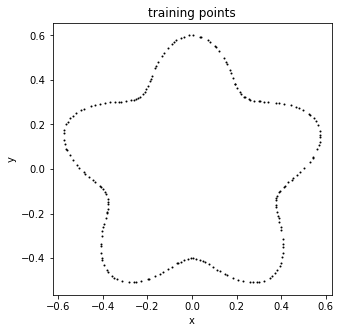

In [10]:
plt.figure(figsize = (5,5))

# plt.scatter(X_inner[:,0], X_inner[:,1],
#             c = "b", s = 1, marker = ".")
# plt.scatter(X_bd[:,0], X_bd[:,1],
#             c = "r", s = 5, marker = ".")
plt.scatter(X_ij[:,0], X_ij[:,1],
            c = "k", s = 1, marker = "o")
plt.xlabel('x')
plt.ylabel('y')
plt.axis('equal')
plt.title('training points')

plt.show()
# Testing points
# Create the grid points


# print(np.hstack((xv[0,1:-1].reshape(-1,1),yv[0,1:-1].reshape(-1,1))))




In [11]:
# single-layer model
model = Plain(2, 40, 1).to(device)
# print(model)

print(f"Number of paramters: {count_parameters(model)}")

# Make model a functional
func_model, func_params = make_functional(model)
# print(func_model, func_params)

Number of paramters: 160


In [12]:
LM_iter = 1000
mu_update = 1 # update \mu every mu_update iterations
div_factor = 1.5 # \mu <- \mu/div_factor when loss decreases
mul_factor = 3 # \mu <- mul_factor*\mu when loss incerases

mu = 10**10
loss_sum_old = 10**10
itera = 0

savedloss = []
savedloss_valid = []

In [13]:
%%time
for step in range(LM_iter+1):
    # Put into loss functional to get L_vec
    L_vec_res = vmap(compute_loss_Res, (None, 0, 0))(func_params, X_ij_torch, Rf_ij_torch)
    #print(L_vec_res.size())
   
    L_vec_j = vmap(compute_loss_j, (None, 0, 0))(func_params, X_ij_torch, Vj_ij_torch)
    L_vec_nj = vmap(compute_loss_normal_jump, (None, 0, 0, 0))(func_params, X_ij_torch, Normal_ij_torch, Vnj_ij_torch)
    # L_vec_res_biharmonic = vmap(compute_loss_Res_biharmonic, (None, 0, 0))(func_params, X_ij_torch, Bihamonics_torch)
    # L_valid_vec_res = vmap(compute_loss_Res, (None, 0, 0))(func_params, X_valid_inner_torch, Rf_valid_inner_torch)

    L_vec_res = L_vec_res/np.sqrt(N)
    # print(L_vec_res.shape)
  
    L_vec_j = L_vec_j/np.sqrt(N)
    L_vec_nj = L_vec_nj/np.sqrt(N)
    # L_vec_res_biharmonic = L_vec_res_biharmonic/np.sqrt(N)
    loss = torch.sum(L_vec_res**2) + torch.sum(L_vec_j**2) + torch.sum(L_vec_nj**2)#+torch.sum(L_vec_res_biharmonic**2)
    
    per_sample_grads = vmap(jacrev(compute_loss_Res), (None, 0, 0))(func_params, X_ij_torch, Rf_ij_torch)
    cnt = 0
    for g in per_sample_grads: 
        g = g.detach()
        J_d_res = g.view(len(g), -1) if cnt == 0 else torch.hstack([J_d_res, g.view(len(g), -1)])
        cnt = 1
        
    per_sample_grads = vmap(jacrev(compute_loss_j), (None, 0, 0))(func_params, X_ij_torch, Vj_ij_torch)
    cnt = 0
    for g in per_sample_grads: 
        g = g.detach()
        J_d_j = g.view(len(g), -1) if cnt == 0 else torch.hstack([J_d_j, g.view(len(g), -1)])
        cnt = 1
        
    per_sample_grads = vmap(jacrev(compute_loss_normal_jump), (None, 0, 0, 0))(func_params, X_ij_torch, Normal_ij_torch, Vnj_ij_torch)
    cnt = 0
    for g in per_sample_grads: 
        g = g.detach()
        J_d_nj = g.contiguous().view(len(g), -1) if cnt == 0 else torch.hstack([J_d_nj, g.view(len(g), -1)])
        cnt = 1
    
    # per_sample_grads = vmap(jacrev(compute_loss_Res_biharmonic), (None, 0, 0))(func_params, X_ij_torch, Bihamonics_torch)
    # cnt = 0
    # for g in per_sample_grads:
    #     g = g.detach()
    #     J_d_biharmonic = g.view(len(g), -1) if cnt == 0 else torch.hstack([J_d_biharmonic, g.view(len(g), -1)])
    #     cnt = 1
    # cat J_d and J_b into J
    J_mat = torch.cat((J_d_res, J_d_j, J_d_nj))#,J_d_biharmonic))
    L_vec = torch.cat((L_vec_res, L_vec_j, L_vec_nj))#,L_vec_res_biharmonic))

    # update lambda
    I = torch.eye((J_mat.shape[1])).to(device)

    with torch.no_grad():
        J_product = J_mat.t()@J_mat
        rhs = -J_mat.t()@L_vec
        with torch.no_grad():
            dp = torch.linalg.solve(J_product + mu*I, rhs)

        # update parameters
        cnt=0
        # print(func_params)
        # print(dp.shape)
        for p in func_params:
            # print(p.shape)
            mm=torch.Tensor([p.shape]).tolist()[0]
            num=int(functools.reduce(lambda x,y:x*y,mm,1))
            p+=dp[cnt:cnt+num].reshape(p.shape)
            cnt+=num
        

        itera += 1
        
        savedloss.append(loss.item())
        # savedloss_valid.append(loss_valid.item())

        if step % mu_update == 0:
            #if loss_sum_check < loss_sum_old:
            if loss < loss_sum_old:
                mu = max(mu/div_factor, 10**(-10))
            else:
                mu = min(mul_factor*mu, 10**(8))
            loss_sum_old = loss
                
        if step>700:
            print(
                    'Iter %d, Loss_Res: %.5e, mu: %.5e' % (itera, loss.item(), mu)
                )            

        if step == LM_iter or loss.item()<10**(-12):
            break

Iter 702, Loss_Res: 9.09589e-12, mu: 3.58500e-09
Iter 703, Loss_Res: 8.77742e-12, mu: 2.39000e-09
Iter 704, Loss_Res: 8.52969e-12, mu: 1.59333e-09
Iter 705, Loss_Res: 8.37504e-12, mu: 1.06222e-09
Iter 706, Loss_Res: 8.37482e-12, mu: 7.08148e-10
Iter 707, Loss_Res: 8.70142e-12, mu: 2.12444e-09
Iter 708, Loss_Res: 9.89711e-12, mu: 6.37333e-09
Iter 709, Loss_Res: 9.62751e-12, mu: 4.24889e-09
Iter 710, Loss_Res: 9.22978e-12, mu: 2.83259e-09
Iter 711, Loss_Res: 8.90758e-12, mu: 1.88839e-09
Iter 712, Loss_Res: 8.67494e-12, mu: 1.25893e-09
Iter 713, Loss_Res: 8.57463e-12, mu: 8.39286e-10
Iter 714, Loss_Res: 8.72277e-12, mu: 2.51786e-09
Iter 715, Loss_Res: 9.45857e-12, mu: 7.55357e-09
Iter 716, Loss_Res: 9.18546e-12, mu: 5.03572e-09
Iter 717, Loss_Res: 8.84027e-12, mu: 3.35714e-09
Iter 718, Loss_Res: 8.55612e-12, mu: 2.23810e-09
Iter 719, Loss_Res: 8.34061e-12, mu: 1.49206e-09
Iter 720, Loss_Res: 8.21943e-12, mu: 9.94709e-10
Iter 721, Loss_Res: 8.26345e-12, mu: 2.98413e-09
Iter 722, Loss_Res: 

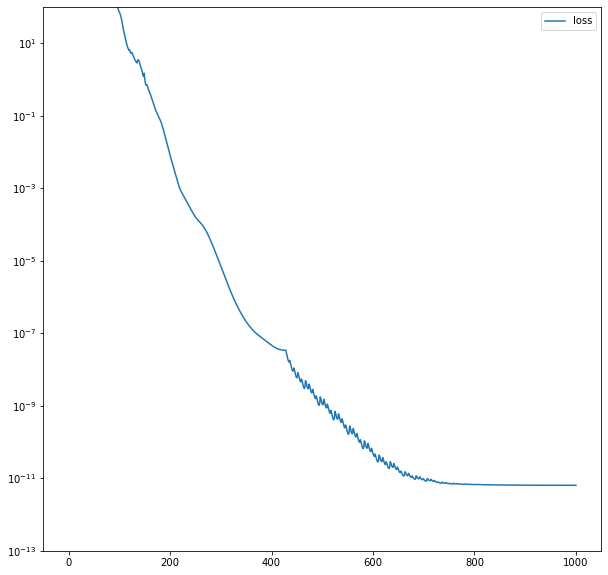

In [14]:
start = 0
end = itera
idx = list(range(start, end, 1))

fig = plt.figure(figsize= (10, 10))
plt.ylim(10**(-13), 10**(2))
plt.yscale("log")
#plt.xscale("log")
plt.plot(idx, savedloss[start:end], label = "loss")
# plt.plot(idx, savedloss_valid[start:end], label = "loss_valid")
plt.legend()
plt.show()

In [15]:
grid_size=257
x_grid = np.linspace(-dd,dd, grid_size)
y_grid = np.linspace(-dd, dd, grid_size)
xv, yv = np.meshgrid(x_grid, y_grid)
z_grid = sign_x(xv, yv)
grid_points = np.vstack([xv.ravel(), yv.ravel()]).T
# print(grid_points[:,-1].shape)

hx = hy = 2.0*dd/(grid_size-1)

In [16]:
class Interface:
    def __init__(self):
        self.AXTP = 0
        self.AXID = 0
        self.ICNR = 0
        self.LGRD = 0
        self.ID = 0
        self.X = 0.0
        self.Y = 0.0
        # self.THETA = 0.0
        #self.RLT2DX = [[0, 0] for _ in range(6)]  # Assuming 2*ODR = 6
        self.GAMMA1 = 0.0
        self.GAMMA2 = 0.0
        self.GAMMA3 = 0.0
        self.GAMMA4 = 0.0
        # JUMP would be an array if used, but it's commented out in the Fortran code
        # self.JUMP = [0.0, 0.0, 0.0]


def set_ifdata(ix, iy, idr, nifp, xo, yo, icnr, ifpxy):
        odr = 3  # For order=4 proble

    # if icnr == 0:
        if idr == 1:  # IDR=1 stands for going in X-direction
            ifpxy[nifp].idr = 1
            ifpxy[nifp].axid = iy
            ifpxy[nifp].icnr = icnr
            ifpxy[nifp].lgrd = ix
            ifpxy[nifp].id = nifp
            ifpxy[nifp].X = xo
            ifpxy[nifp].Y = yo
            ifpxy[nifp].ix=ix
            ifpxy[nifp].iy=iy
           

            # Assuming XI is some predefined array
            ifpxy[nifp].gamma1 = x_grid[ifpxy[nifp].lgrd - 1] - ifpxy[nifp].X
            ifpxy[nifp].gamma2 = x_grid[ifpxy[nifp].lgrd] - ifpxy[nifp].X
            ifpxy[nifp].gamma3 = x_grid[ifpxy[nifp].lgrd + 1] - ifpxy[nifp].X
            ifpxy[nifp].gamma4 = x_grid[ifpxy[nifp].lgrd + 2] - ifpxy[nifp].X

        elif idr == 0:  # IDR=0 stands for going in Y-direction
            ifpxy[nifp].idr = 0
            ifpxy[nifp].axid = ix
            ifpxy[nifp].icnr = icnr
            ifpxy[nifp].lgrd = iy
            ifpxy[nifp].id = nifp
            ifpxy[nifp].X = xo
            ifpxy[nifp].Y = yo
            ifpxy[nifp].ix=ix
            ifpxy[nifp].iy=iy
           
            
            # Assuming YI is some predefined array
            ifpxy[nifp].gamma1 = y_grid[ifpxy[nifp].lgrd - 1] - ifpxy[nifp].Y
            ifpxy[nifp].gamma2 = y_grid[ifpxy[nifp].lgrd] - ifpxy[nifp].Y
            ifpxy[nifp].gamma3 = y_grid[ifpxy[nifp].lgrd + 1] - ifpxy[nifp].Y
            ifpxy[nifp].gamma4 = y_grid[ifpxy[nifp].lgrd + 2] - ifpxy[nifp].Y



# Create an array of Interface objects
ifpxy = [Interface() for _ in range(N*2*2)]  



In [17]:
from IPython.display import display
z_grid = sign_x(xv, yv)

    # return intersections
def find_interface_intersections(x_grid, y_grid, z_grid):
    intersections = []  # Use a set to store unique intersections
    nifp = 0

    # Convert grids to NumPy arrays (if not already)

    # Find crossings in the x-direction
    x_crossing_mask = (z_grid[:-4, 1:-1] != z_grid[1:-3, 1:-1]) & \
                      (z_grid[1:-3, 1:-1] == z_grid[2:-2, 1:-1]) & \
                      (z_grid[2:-2, 1:-1] == z_grid[3:-1, 1:-1])

    x_cross_indices = np.argwhere(x_crossing_mask)
    # print(len(x_cross_indices))
   
    if len(x_cross_indices) > 0:
        for idx in x_cross_indices:
            i, j = idx
            j+=1

            if(z_grid[i-1, j] != z_grid[i, j] or z_grid[i-1, j] != z_grid[i-2, j]):
                print('error in cross',i,j,z_grid[i, j], z_grid[i-1, j], z_grid[i-2, j])
                continue
          
                
            nifp += 1
            icnr = 0
            x_intersection = xv[i, j]
           
            theta_intersection =find_intersect_theta(yv[i,j],yv[i+1,j],x_intersection,'x')
            y_intersection = (aa + bb * np.sin(cc * theta_intersection)) * np.sin(theta_intersection)
            intersections.append(np.hstack([x_intersection, y_intersection]))
            set_ifdata(ix=j, iy=i, idr=0, nifp=nifp, xo=x_intersection, yo= y_intersection, icnr=0, ifpxy=ifpxy)
            if( abs(ifpxy[nifp].gamma2)>=hx or abs(ifpxy[nifp].gamma3)>=hx ):
                print('yv[i,j]',yv[i,j],'yv[i+1,j]',yv[i+1,j],'x_intersection',x_intersection)
                theta1=get_angle(xv[i,j],yv[i,j],np.sqrt(xv[i,j]**2+yv[i,j]**2))
                theta2=get_angle(xv[i+1,j],yv[i+1,j],np.sqrt(xv[i+1,j]**2+yv[i+1,j]**2))
                print('theta1:',theta1,'theta2:',theta2)
                print('(aa + bb * np.sin(cc * theta)) * np.cos(theta)',(aa + bb * np.sin(cc * theta1)) * np.cos(theta1)-x_intersection)
                print('(aa + bb * np.sin(cc * theta)) * np.cos(theta)',(aa + bb * np.sin(cc * theta2)) * np.cos(theta2)-x_intersection)
                print(theta_intersection)
                print('error in gammay',ifpxy[nifp].X,ifpxy[nifp].Y,ifpxy[nifp].gamma1,ifpxy[nifp].gamma2,ifpxy[nifp].gamma3,ifpxy[nifp].gamma4,ifpxy[nifp].ix,ifpxy[nifp].iy,hx)
        
                print('nifp',nifp,'xv[i,j]',xv[i,j],'yv[i,j]',yv[i,j])
            if i==23 and j==18:
                print(i,j,nifp,ifpxy[nifp].X,ifpxy[nifp].Y,ifpxy[nifp].gamma1,ifpxy[nifp].gamma2,ifpxy[nifp].gamma3,ifpxy[nifp].gamma4,ifpxy[nifp].ix,ifpxy[nifp].iy)
                print(abs(ifpxy[nifp].gamma1)>hx,abs(ifpxy[nifp].gamma2)>hx,abs(ifpxy[nifp].gamma3)>hx,abs(ifpxy[nifp].gamma4)>hx)
               # print('x:',ifpxy[nifp].X,'y:',ifpxy[nifp].Y,'gamma1:',ifpxy[nifp].GAMMA1,'ifpxy[nifp].LGRD:', y_grid[ifpxy[nifp].LGRD],yv[i,j],y_sign)
    print('single intersection in y',nifp)
    x_crossing_mask = (z_grid[:-4, 1:-1] != z_grid[1:-3, 1:-1]) & \
                      (z_grid[1:-3, 1:-1] == z_grid[2:-2, 1:-1]) & \
                      (z_grid[2:-2, 1:-1] != z_grid[3:-1, 1:-1])
    
    x_cross_indices = np.argwhere(x_crossing_mask)
    if len(x_cross_indices) > 0:
        
        for idx in x_cross_indices:
            print('corner 2 crossy')
            i, j = idx
            j+=1
            nifp += 1
            icnr = -2
            x_intersection = xv[i, j]
            # print(z_grid[i,j],z_grid[i+1,j],z_grid[i+2,j],z_grid[i+3,j],i,j,xv[i,j],yv[i,j])
            theta_intersection = find_intersect_theta(yv[i,j],yv[i+1,j],x_intersection,'x')
            y_intersection = (aa + bb * np.sin(cc * theta_intersection)) * np.sin(theta_intersection)
            intersections.append(np.hstack([x_intersection, y_intersection]))
            set_ifdata(ix=j, iy=i, idr=0, nifp=nifp, xo=x_intersection, yo=y_intersection, icnr=icnr, ifpxy=ifpxy)
        
            theta_intersection = find_intersect_theta(yv[i+2,j],yv[i+3,j],x_intersection,'x')
            y_intersection = (aa + bb * np.sin(cc * theta_intersection)) * np.sin(theta_intersection)
            nifp += 1
            icnr = 2
            intersections.append(np.hstack([x_intersection, y_intersection]))
            set_ifdata(ix=j, iy=i+2, idr=0, nifp=nifp, xo=x_intersection, yo=y_intersection, icnr=icnr, ifpxy=ifpxy)
            print(ifpxy[nifp].X,ifpxy[nifp].Y,ifpxy[nifp].gamma1,ifpxy[nifp].gamma2,ifpxy[nifp].gamma3,ifpxy[nifp].gamma4,ifpxy[nifp].ix,ifpxy[nifp].iy)
        
    x_crossing_mask = (z_grid[:-4, 1:-1] != z_grid[1:-3, 1:-1]) & \
                        (z_grid[1:-3, 1:-1] != z_grid[2:-2, 1:-1])
    x_cross_indices = np.argwhere(x_crossing_mask)
    if len(x_cross_indices) > 0:
       
        for idx in x_cross_indices:
            print('corner 1 crossy')
            i, j = idx
            j+=1
            nifp += 1
            icnr = -1
            x_intersection = xv[i, j]
            # print(z_grid[i,j],z_grid[i+1,j],z_grid[i+2,j],z_grid[i+3,j],i,j,xv[i,j],yv[i,j])
            theta_intersection = find_intersect_theta(yv[i,j],yv[i+1,j],x_intersection,'x')
            y_intersection = (aa + bb * np.sin(cc * theta_intersection)) * np.sin(theta_intersection)
            intersections.append(np.hstack([x_intersection, y_intersection]))
            set_ifdata(ix=j, iy=i, idr=0, nifp=nifp, xo=x_intersection, yo=y_intersection, icnr=icnr, ifpxy=ifpxy)
        
            theta_intersection = find_intersect_theta(yv[i+1,j],yv[i+2,j],x_intersection,'x')
            y_intersection = (aa + bb * np.sin(cc * theta_intersection)) * np.sin(theta_intersection)
            nifp += 1
            icnr = 1
            intersections.append(np.hstack([x_intersection, y_intersection]))
            set_ifdata(ix=j, iy=i+1, idr=0, nifp=nifp, xo=x_intersection, yo=y_intersection, icnr=icnr, ifpxy=ifpxy)
            print(ifpxy[nifp].X,ifpxy[nifp].Y,ifpxy[nifp].gamma1,ifpxy[nifp].gamma2,ifpxy[nifp].gamma3,ifpxy[nifp].gamma4,ifpxy[nifp].ix,ifpxy[nifp].iy)
        
    # Find crossings in the y-direction
    y_crossing_mask = (z_grid[1:-1, :-4] != z_grid[1:-1, 1:-3]) & \
                      (z_grid[1:-1, 1:-3] == z_grid[1:-1, 2:-2]) & \
                      (z_grid[1:-1, 2:-2] == z_grid[1:-1, 3:-1])

    y_cross_indices = np.argwhere(y_crossing_mask)
    # print(len(y_cross_indices))
    if len(y_cross_indices) > 0:
        for idx in y_cross_indices:
            i, j = idx
            i+=1
            if(z_grid[i, j-1] != z_grid[i, j] or z_grid[i, j-1] != z_grid[i, j-2]):
 
                print('error in cross',i,j,z_grid[i, j], z_grid[i, j-1], z_grid[i, j-2])
                continue
            nifp += 1
            icnr = 0
            y_intersection = yv[i, j]
            theta_intersection = find_intersect_theta(xv[i,j],xv[i,j+1],yv[i,j],'y')
            x_intersection = (aa + bb * np.sin(cc * theta_intersection)) * np.cos(theta_intersection)
            intersections.append(np.hstack([x_intersection, y_intersection]))
            set_ifdata(ix=j, iy=i, idr=1, nifp=nifp, xo=x_intersection, yo=y_intersection, icnr=icnr, ifpxy=ifpxy)
            if( abs(ifpxy[nifp].gamma2)>=hx or abs(ifpxy[nifp].gamma3)>=hx ):
                print('error in gammax',ifpxy[nifp].X,ifpxy[nifp].Y,ifpxy[nifp].gamma1,ifpxy[nifp].gamma2,ifpxy[nifp].gamma3,ifpxy[nifp].gamma4,ifpxy[nifp].ix,ifpxy[nifp].iy)
    y_crossing_mask = (z_grid[1:-1, :-4] != z_grid[1:-1, 1:-3]) & \
                      (z_grid[1:-1, 1:-3] == z_grid[1:-1, 2:-2]) & \
                      (z_grid[1:-1, 2:-2] != z_grid[1:-1, 3:-1])

    y_cross_indices = np.argwhere(y_crossing_mask)
    # print(len(y_cross_indices))
    if len(y_cross_indices) > 0:
      
        for idx in y_cross_indices:
            print('corner 2 crossx')
            i, j = idx
            i+=1
            nifp += 1
            icnr = -2
            y_intersection = yv[i, j]
            theta_intersection = find_intersect_theta(xv[i,j],xv[i,j+1],yv[i,j],'y')
            x_intersection = (aa + bb * np.sin(cc * theta_intersection)) * np.cos(theta_intersection)
            intersections.append(np.hstack([x_intersection, y_intersection]))
            set_ifdata(ix=j, iy=i, idr=1, nifp=nifp, xo=x_intersection, yo=y_intersection, icnr=icnr, ifpxy=ifpxy)

            nifp += 1
            icnr = 2
            y_intersection = yv[i, j]
            # print(z_grid[i,j],z_grid[i,j+1],z_grid[i,j+2],z_grid[i,j+3],i,j,xv[i,j],yv[i,j])
            theta_intersection = find_intersect_theta(xv[i,j+2],xv[i,j+3],yv[i,j],'y')
            x_intersection = (aa + bb * np.sin(cc * theta_intersection)) * np.cos(theta_intersection)
            intersections.append(np.hstack([x_intersection, y_intersection]))
            set_ifdata(ix=j+2, iy=i, idr=1, nifp=nifp, xo=x_intersection, yo=y_intersection, icnr=icnr, ifpxy=ifpxy)
            print(ifpxy[nifp].X,ifpxy[nifp].Y,ifpxy[nifp].gamma1,ifpxy[nifp].gamma2,ifpxy[nifp].gamma3,ifpxy[nifp].gamma4,ifpxy[nifp].ix,ifpxy[nifp].iy)


    y_crossing_mask = (z_grid[1:-1, :-4] != z_grid[1:-1, 1:-3]) & \
                        (z_grid[1:-1, 1:-3] != z_grid[1:-1, 2:-2])
    y_cross_indices = np.argwhere(y_crossing_mask)
    if len(y_cross_indices) > 0:
       for idx in y_cross_indices:
            print('corner 1 crossx')
            i, j = idx
            i+=1
            nifp += 1
            icnr = -1
            y_intersection = yv[i, j]
            theta_intersection = find_intersect_theta(xv[i,j],xv[i,j+1],yv[i,j],'y')
            x_intersection = (aa + bb * np.sin(cc * theta_intersection)) * np.cos(theta_intersection)
            intersections.append(np.hstack([x_intersection, y_intersection]))
            set_ifdata(ix=j, iy=i, idr=1, nifp=nifp, xo=x_intersection, yo=y_intersection, icnr=icnr, ifpxy=ifpxy)

            nifp += 1
            icnr = 1
            y_intersection = yv[i, j]
            # print(z_grid[i,j],z_grid[i,j+1],z_grid[i,j+2],z_grid[i,j+3],i,j,xv[i,j],yv[i,j])
            theta_intersection = find_intersect_theta(xv[i,j+1],xv[i,j+2],yv[i,j],'y')
            x_intersection = (aa + bb * np.sin(cc * theta_intersection)) * np.cos(theta_intersection)
            intersections.append(np.hstack([x_intersection, y_intersection]))
            set_ifdata(ix=j+1, iy=i, idr=1, nifp=nifp, xo=x_intersection, yo=y_intersection, icnr=icnr, ifpxy=ifpxy)
            print(ifpxy[nifp].X,ifpxy[nifp].Y,ifpxy[nifp].gamma1,ifpxy[nifp].gamma2,ifpxy[nifp].gamma3,ifpxy[nifp].gamma4,ifpxy[nifp].ix,ifpxy[nifp].iy)

    
    print('nifp',nifp)
    return intersections
# Get the intersections


single intersection in y 298
nifp 598
(598, 2)
All rows in intersections match the concatenated arrays.
Number of unique intersections: 598
max(abs(Q)) 6231.467257078097
ux 2.332865373855242e-05
uy 1.937181484867878e-05
uxxx 0.0799730791097204
uyyy 0.03090048164342374
uxx 0.0003809207703255879
uyy 0.00038160616539428815
uxxxx 4.094784748725942
uyyyy 1.6976172738422974


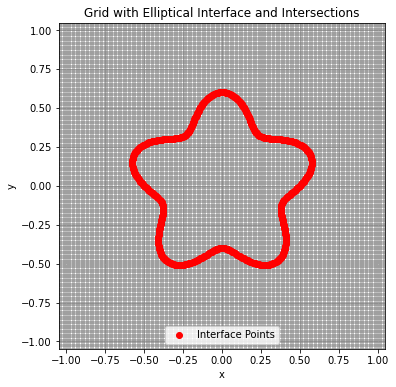

In [18]:

intersections = find_interface_intersections(x_grid, y_grid, z_grid)
# print(intersections)
nifp=len(intersections)



intersection_array = np.array(intersections)
# print(intersection_array.shape)
print(intersection_array.shape)
same = True  # Initialize as True, will change to False if a mismatch is found
for i in range(nifp):
    concatenated_array = np.hstack([ifpxy[i+1].X, ifpxy[i+1].Y])
    
    # Check if the corresponding row in intersections is close to the concatenated array
    if not np.allclose(intersection_array[i], concatenated_array):
        print(intersection_array[i], concatenated_array,i)
        same = False
        break  # No need to continue if a mismatch is found

if same:
    print("All rows in intersections match the concatenated arrays.")
else:
    print("There is a mismatch in one or more rows.")

# Plot the grid and the intersections
# Plot the grid
plt.figure(figsize=(6, 6))
plt.plot(xv, yv, color='grey', linestyle='-', linewidth=0.5)  # Vertical grid lines
plt.plot(xv.T, yv.T, color='grey', linestyle='-', linewidth=0.5)  # Horizontal grid lines


# Count the number of unique intersections
num_intersections = len(intersections)
print(f"Number of unique intersections: {num_intersections}")

# Remove duplicate intersections by converting the list to a set and back to a list


X_intersect_torch = torch.tensor(intersection_array).double().to(device)


u_xpred,u_ypred = vmap(compute_first_jump, (None, 0))(func_params, X_intersect_torch)

u_xpred = u_xpred.detach().cpu().numpy()
u_ypred = u_ypred.detach().cpu().numpy()

u_xxpred,u_yypred = vmap(compute_second_jump, (None, 0))(func_params, X_intersect_torch)

u_xxpred = u_xxpred.detach().cpu().numpy()
u_yypred = u_yypred.detach().cpu().numpy()

u_xxxpred,u_yyypred = vmap(compute_third_jump, (None, 0))(func_params, X_intersect_torch)
u_xxxpred = u_xxxpred.detach().cpu().numpy()
u_yyypred = u_yyypred.detach().cpu().numpy()

u_xxxxpred,u_yyyypred = vmap(compute_fourth_jump, (None, 0))(func_params, X_intersect_torch)
u_xxxxpred = u_xxxxpred.detach().cpu().numpy()
u_yyyypred = u_yyyypred.detach().cpu().numpy()

Q = np.zeros(nifp*5)
for i in range(nifp):
    sign=1 if z_grid[ifpxy[i+1].iy,ifpxy[i+1].ix]<0 else -1
   
    Q[i*5]= sign*(exact_u(ifpxy[i+1].X, ifpxy[i+1].Y, 1.0) - exact_u(ifpxy[i+1].X, ifpxy[i+1].Y,-1.0))
    Q[i*5+1]=-sign*u_xpred[i] if ifpxy[i+1].idr==1 else -sign*u_ypred[i]
    Q[i*5+2]=-sign*u_xxpred[i] if ifpxy[i+1].idr==1 else -sign*u_yypred[i]
    Q[i*5+3]=-sign*u_xxxpred[i] if ifpxy[i+1].idr==1 else -sign*u_yyypred[i]
    Q[i*5+4]=-sign*u_xxxxpred[i] if ifpxy[i+1].idr==1 else -sign*u_yyyypred[i]

print('max(abs(Q))',max(abs(Q)))
df1_ux,df1_uy=df1(intersection_array[:,0], intersection_array[:,1])
error=abs(u_xpred.flatten()+df1_ux.flatten())
print('ux',np.linalg.norm(error,np.inf))

error=abs(u_ypred.flatten()+df1_uy.flatten())
print('uy',np.linalg.norm(error,np.inf))

df2_xx,df2_yy = df2(intersection_array[:,0], intersection_array[:,1])
df3_xxx, df3_yyy = df3(intersection_array[:,0], intersection_array[:,1])
error=abs(u_xxxpred.flatten()+df3_xxx.flatten())

print('uxxx',np.linalg.norm(error,np.inf))

error=abs(u_yyypred.flatten()+df3_yyy.flatten())
print('uyyy',np.linalg.norm(error,np.inf))
error=abs(u_xxpred.flatten()+df2_xx.flatten())
print('uxx',np.linalg.norm(error,np.inf))

error=abs(u_yypred.flatten()+df2_yy.flatten())
print('uyy',np.linalg.norm(error,np.inf))

df4_xxxx, df4_yyyy = df4(intersection_array[:,0], intersection_array[:,1])
error=abs(u_xxxxpred.flatten()+df4_xxxx.flatten())
print('uxxxx',np.linalg.norm(error,np.inf))
error=abs(u_yyyypred.flatten()+df4_yyyy.flatten())
print('uyyyy',np.linalg.norm(error,np.inf))


max_indices=np.argmax(error)

if intersections:
    x_vals, y_vals = zip(*intersections)
    plt.scatter(x_vals, y_vals, color='red', label='Interface Points', zorder=5)


plt.grid(True)
plt.title('Grid with Elliptical Interface and Intersections')
plt.xlabel('x')
plt.ylabel('y')
plt.xlim([-dd, dd])
plt.ylim([-dd, dd])
plt.gca().set_aspect('equal', adjustable='box')
plt.legend()
plt.show()


In [19]:
import scipy.sparse as sp

def create_matrix_b(nifp, ifpxy, hx, nx,a1,a2,a12):
    # Initialize the necessary constants
    weis = np.array([1.0, 1.0, 0.5, 1.0 / 6.0, 1.0 / 24.0])
    c1 = 1.0 / 12.0 / hx / hx
    c2 = 4.0 / 3.0 / hx / hx
    c3 = 1.0 / 12.0 / hx
    c4 = 2.0 / 3.0 / hx

    # Preallocate lists for indices and values of matrix B
    matrix_ix = []
    matrix_iy = []
    matrix_vb = []

    i=0
    while True:
        elemt = ifpxy[i+1]
        ix = elemt.ix
        iy = elemt.iy
        gamma3 = elemt.gamma3
        gamma_powers_3 = np.power(gamma3, np.arange(5))

        gamma4 = elemt.gamma4
        gamma_powers_4 = np.power(gamma4, np.arange(5))

        gamma1=elemt.gamma1
        gamma_powers_1 = np.power(gamma1, np.arange(5))

        gamma2=elemt.gamma2
        gamma_powers_2 = np.power(gamma2, np.arange(5))
        if elemt.icnr == 0:
            if elemt.idr == 0:
                
                # Add entries to matrix B
                for k in range(5):
                    matrix_ix.append((iy - 1) * nx + ix)
                    matrix_iy.append((elemt.id - 1) * 5 + k )
                    matrix_vb.append(weis[k] * gamma_powers_3[k] *  (c1*a2+c3*a1)) 

                # Below the interface (close point)
                for k in range(5):
                    matrix_ix.append((iy) * nx + ix)
                    matrix_iy.append((elemt.id - 1) * 5 + k )
                    matrix_vb.append(weis[k] * gamma_powers_4[k] * (c1*a2+c3*a1)  +
                                     weis[k] * gamma_powers_3[k] * (-c2*a2-c4*a1))

                # Above the interface (first point)

                for k in range(5):
                    matrix_ix.append((iy+1) * nx + ix)
                    matrix_iy.append((elemt.id - 1) * 5 + k)
                    matrix_vb.append(weis[k] * gamma_powers_1[k] * (-c1*a2+c3*a1 ) +
                                     weis[k] * gamma_powers_2[k] * (c2*a2-c4*a1) )

                # Above the interface (second point)

                for k in range(5):
                    matrix_ix.append((iy+2) * nx + ix)
                    matrix_iy.append((elemt.id - 1) * 5 + k)
                    matrix_vb.append(weis[k] * gamma_powers_2[k] * (-c1*a2+c3*a1))

            elif elemt.idr == 1:
                # Left and right of the interface logic (similar to above)

                # Farther point left
                for k in range(5):
                    matrix_ix.append((iy) * nx + ix - 1)
                    matrix_iy.append((elemt.id - 1) * 5 + k )
                    matrix_vb.append(weis[k] * gamma_powers_3[k] * (c1*a2+c3*a12))

                # Close point left

                for k in range(5):
                    matrix_ix.append((iy) * nx + ix)
                    matrix_iy.append((elemt.id - 1) * 5 + k)
                    matrix_vb.append(weis[k] * gamma_powers_4[k] * ( c1*a2+c3*a12 ) +
                                     weis[k] * gamma_powers_3[k] * (- c2*a2-c4*a12))

                # Right of the interface (first and second points) similar to above...
                 # Above the interface (first point)
                for k in range(5):
                    matrix_ix.append((iy) * nx + ix+1)
                    matrix_iy.append((elemt.id - 1) * 5 + k)
                    matrix_vb.append(weis[k] * gamma_powers_1[k] * (-c1*a2+c3*a12 ) +
                                     weis[k] * gamma_powers_2[k] * (c2*a2-c4*a12) )

                # Above the interface (second point)

                for k in range(5):
                    matrix_ix.append((iy) * nx + ix+2)
                    matrix_iy.append((elemt.id - 1) * 5 + k)
                    matrix_vb.append(weis[k] * gamma_powers_2[k] * (-c1*a2+c3*a12))
            i+=1
            # print(i)

        elif elemt.icnr ==-2:
            # print(elemt.id,i+1)
            elemt2=ifpxy[i+2]
            # print(i+2)
            if elemt.idr == 0:
            
                # Add entries to matrix B
                for k in range(5):
                    matrix_ix.append((iy - 1) * nx + ix)
                    matrix_iy.append((elemt.id - 1) * 5 + k )
                    matrix_vb.append(weis[k] * gamma_powers_3[k] *  (c1*a2+c3*a1))
                    # print((iy - 1) * nx + ix,(elemt.id - 1) * 5 + k,weis[k] * gamma_powers_3[k] *  (c1*a2+c3*a1))
                

                # Below the interface (close point)
                for k in range(5):
                    matrix_ix.append((iy) * nx + ix)
                    matrix_iy.append((elemt.id - 1) * 5 + k )
                    matrix_vb.append(weis[k] * gamma_powers_4[k] * (c1*a2+c3*a1)  +
                                     weis[k] * gamma_powers_3[k] * (-c2*a2-c4*a1))
                    # print((iy) * nx + ix,(elemt.id - 1) * 5 + k,weis[k] * gamma_powers_4[k] * (c1*a2+c3*a1)  +
                    #                  weis[k] * gamma_powers_3[k] * (-c2*a2-c4*a1))
                    
                    
                for k in range(5):
                    matrix_ix.append((iy+1) * nx + ix)
                    matrix_iy.append((elemt.id - 1) * 5 + k)
                    matrix_vb.append(weis[k] * gamma_powers_1[k] * (-c1*a2+c3*a1)  +
                                     weis[k] * gamma_powers_2[k] * (c2*a2-c4*a1))
                    # print((iy+1) * nx + ix,(elemt.id - 1) * 5 + k,weis[k] * gamma_powers_1[k] * (-c1*a2+c3*a1)  +
                    #                  weis[k] * gamma_powers_2[k] * (c2*a2-c4*a1))
                
                gamma3 = elemt2.gamma3
                gamma_powers_3 = np.power(gamma3, np.arange(5))
                for k in range(5):
                    matrix_ix.append((iy+1) * nx + ix)
                    matrix_iy.append((elemt2.id - 1) * 5 + k)
                    matrix_vb.append(weis[k] * gamma_powers_3[k] * (c1*a2+c3*a1))
                    # print((iy+1) * nx + ix,(elemt2.id - 1) * 5 + k,weis[k] * gamma_powers_3[k] * (c1*a2+c3*a1))
                for k in range(5):
                    matrix_ix.append((iy+2) * nx + ix)
                    matrix_iy.append((elemt.id - 1) * 5 + k)
                    matrix_vb.append(weis[k] * gamma_powers_2[k] * (-c1*a2+c3*a1))
                    # print((iy+2) * nx + ix,(elemt.id - 1) * 5 + k,weis[k] * gamma_powers_2[k] * (-c1*a2+c3*a1))


                gamma4 = elemt2.gamma4
                gamma_powers_4 = np.power(gamma4, np.arange(5))

                for k in range(5):
                    matrix_ix.append((iy+2) * nx + ix)
                    matrix_iy.append((elemt2.id - 1) * 5 + k)
                    matrix_vb.append(weis[k] * gamma_powers_4[k] * (c1*a2+c3*a1)  +
                                     weis[k] * gamma_powers_3[k] * (-c2*a2-c4*a1))
                    # print((iy+2) * nx + ix,(elemt2.id - 1) * 5 + k,weis[k] * gamma_powers_4[k] * (c1*a2+c3*a1)  +
                    #                  weis[k] * gamma_powers_3[k] * (-c2*a2-c4*a1))
                    
                gamma1=elemt2.gamma1
                gamma_powers_1 = np.power(gamma1, np.arange(5))

                gamma2=elemt2.gamma2
                gamma_powers_2 = np.power(gamma2, np.arange(5))  

                for k in range(5):
                    matrix_ix.append((iy+3) * nx + ix)
                    matrix_iy.append((elemt2.id - 1) * 5 + k)
                    matrix_vb.append(weis[k] * gamma_powers_1[k] * (-c1*a2+c3*a1)  +
                                     weis[k] * gamma_powers_2[k] * (c2*a2-c4*a1))
                    # print((iy+3) * nx + ix,(elemt2.id - 1) * 5 + k,weis[k] * gamma_powers_1[k] * (-c1*a2+c3*a1)  +
                    #                  weis[k] * gamma_powers_2[k] * (c2*a2-c4*a1))
   
                for k in range(5):
                    matrix_ix.append((iy+4) * nx + ix)
                    matrix_iy.append((elemt2.id - 1) * 5 + k)
                    matrix_vb.append(weis[k] * gamma_powers_2[k] * (-c1*a2+c3*a1))
                    # print((iy+4) * nx + ix,(elemt2.id - 1) * 5 + k,weis[k] * gamma_powers_2[k] * (-c1*a2+c3*a1))
            elif elemt.idr == 1:

                # Add entries to matrix B
                for k in range(5):
                    matrix_ix.append((iy) * nx + ix-1)
                    matrix_iy.append((elemt.id - 1) * 5 + k )
                    matrix_vb.append(weis[k] * gamma_powers_3[k] *  (c1*a2+c3*a12))

                # Below the interface (close point)
                for k in range(5):
                    matrix_ix.append((iy) * nx + ix)
                    matrix_iy.append((elemt.id - 1) * 5 + k )
                    matrix_vb.append(weis[k] * gamma_powers_4[k] * (c1*a2+c3*a12)  +
                                     weis[k] * gamma_powers_3[k] * (-c2*a2-c4*a12))
                    
                for k in range(5):
                    matrix_ix.append((iy) * nx + ix+1)
                    matrix_iy.append((elemt.id - 1) * 5 + k)
                    matrix_vb.append(weis[k] * gamma_powers_1[k] * (-c1*a2+c3*a12)  +
                                     weis[k] * gamma_powers_2[k] * (c2*a2-c4*a12))
                    
                gamma3 = elemt2.gamma3
                gamma_powers_3 = np.power(gamma3, np.arange(5))
                for k in range(5):
                    matrix_ix.append((iy) * nx + ix+1)
                    matrix_iy.append((elemt2.id - 1) * 5 + k)
                    matrix_vb.append(weis[k] * gamma_powers_3[k] * (c1*a2+c3*a12))


                for k in range(5):
                    matrix_ix.append((iy) * nx + ix+2)
                    matrix_iy.append((elemt.id - 1) * 5 + k)
                    matrix_vb.append(weis[k] * gamma_powers_2[k] * (-c1*a2+c3*a12))

    
                gamma4 = elemt2.gamma4
                gamma_powers_4 = np.power(gamma4, np.arange(5))

                for k in range(5):
                    matrix_ix.append((iy) * nx + ix+2)
                    matrix_iy.append((elemt2.id - 1) * 5 + k)
                    matrix_vb.append(weis[k] * gamma_powers_4[k] * (c1*a2+c3*a12)  +
                                     weis[k] * gamma_powers_3[k] * (-c2*a2-c4*a12))
                    
                gamma1=elemt2.gamma1
                gamma_powers_1 = np.power(gamma1, np.arange(5))

                gamma2=elemt2.gamma2
                gamma_powers_2 = np.power(gamma2, np.arange(5))

                for k in range(5):
                    matrix_ix.append((iy) * nx + ix+3)
                    matrix_iy.append((elemt2.id - 1) * 5 + k)
                    matrix_vb.append(weis[k] * gamma_powers_1[k] * (-c1*a2+c3*a12)  +
                                     weis[k] * gamma_powers_2[k] * (c2*a2-c4*a12))
                
                for k in range(5):
                    matrix_ix.append((iy) * nx + ix+4)
                    matrix_iy.append((elemt2.id - 1) * 5 + k)
                    matrix_vb.append(weis[k] * gamma_powers_2[k] * (-c1*a2+c3*a12))
            i+=2
        elif elemt.icnr == -1:
            elemt2=ifpxy[i+2]
            # print(i+2)
            if elemt.idr == 0:
               
                for k in range(5):
                    matrix_ix.append((iy - 1) * nx + ix)
                    matrix_iy.append((elemt.id - 1) * 5 + k )
                    matrix_vb.append(weis[k] * gamma_powers_3[k] *  (c1*a2+c3*a1)) 

                # Below the interface (close point)
                for k in range(5):
                    matrix_ix.append( (iy) * nx + ix)
                    matrix_iy.append((elemt.id - 1) * 5 + k )
                    matrix_vb.append(weis[k] * gamma_powers_3[k] * (-c2*a2-c4*a1))

                # Above the interface (first point)
             

                for k in range(5):
                    matrix_ix.append((iy+1) * nx + ix)
                    matrix_iy.append((elemt.id - 1) * 5 + k)
                    matrix_vb.append(weis[k] * gamma_powers_1[k] * (-c1*a2+c3*a1 ) +
                                     weis[k] * gamma_powers_2[k] * (c2*a2-c4*a1) )
                    

                gamma3 = elemt2.gamma3
                gamma_powers_3 = np.power(gamma3, np.arange(5))

                gamma4 = elemt2.gamma4
                gamma_powers_4 = np.power(gamma4, np.arange(5))

                gamma2=elemt2.gamma2
                gamma_powers_2 = np.power(gamma2, np.arange(5))
                for k in range(5):
                    matrix_ix.append((iy+1) * nx + ix)
                    matrix_iy.append((elemt2.id - 1) * 5 + k)
                    matrix_vb.append(weis[k] * gamma_powers_3[k] * (-c2*a2-c4*a1 ) +
                                     weis[k] * gamma_powers_4[k] * (c1*a2+c3*a1) )
                
                for k in range(5):
                    matrix_ix.append((iy+2) * nx + ix)
                    matrix_iy.append((elemt2.id - 1) * 5 + k)
                    matrix_vb.append(weis[k] * gamma_powers_2[k] * (c2*a2-c4*a1) )
                
                for k in range(5):
                    matrix_ix.append((iy+3) * nx + ix)
                    matrix_iy.append((elemt2.id - 1) * 5 + k)
                    matrix_vb.append(weis[k] * gamma_powers_2[k] * (-c1*a2+c3*a1))
            elif elemt.idr == 1:
               
                for k in range(5):
                    matrix_ix.append((iy) * nx + ix-1)
                    matrix_iy.append((elemt.id - 1) * 5 + k )
                    matrix_vb.append(weis[k] * gamma_powers_3[k] *  (c1*a2+c3*a12)) 

                # Below the interface (close point)
                for k in range(5):
                    matrix_ix.append( (iy) * nx + ix)
                    matrix_iy.append((elemt.id - 1) * 5 + k )
                    matrix_vb.append(weis[k] * gamma_powers_3[k] * (-c2*a2-c4*a12))

                # Above the interface (first point)
             

                for k in range(5):
                    matrix_ix.append((iy) * nx + ix+1)
                    matrix_iy.append((elemt.id - 1) * 5 + k)
                    matrix_vb.append(weis[k] * gamma_powers_1[k] * (-c1*a2+c3*a12 ) +
                                     weis[k] * gamma_powers_2[k] * (c2*a2-c4*a12) )

                gamma3 = elemt2.gamma3
                gamma_powers_3 = np.power(gamma3, np.arange(5))

                gamma4 = elemt2.gamma4
                gamma_powers_4 = np.power(gamma4, np.arange(5))

                gamma2=elemt2.gamma2
                gamma_powers_2 = np.power(gamma2, np.arange(5))
                for k in range(5):
                    matrix_ix.append((iy) * nx + ix +1)
                    matrix_iy.append((elemt2.id - 1) * 5 + k)
                    matrix_vb.append(weis[k] * gamma_powers_3[k] * (-c2*a2-c4*a12 ) +
                                     weis[k] * gamma_powers_4[k] * (c1*a2+c3*a12) )
                
                for k in range(5):
                    matrix_ix.append((iy) * nx + ix+2)
                    matrix_iy.append((elemt2.id - 1) * 5 + k)
                    matrix_vb.append(weis[k] * gamma_powers_2[k] * (c2*a2-c4*a12) )
                
                for k in range(5):
                    matrix_ix.append((iy) * nx + ix+3)
                    matrix_iy.append((elemt2.id - 1) * 5 + k)
                    matrix_vb.append(weis[k] * gamma_powers_2[k] * (-c1*a2+c3*a12))
            i+=2
        if i >= nifp:
            # print('break',i)
            break  
    list1=matrix_ix
    list2=matrix_iy
    repeated_positions = []
    for i in range(min(len(list1), len(list2))):
        if list1.count(list1[i]) > 1 and list2.count(list2[i]) > 1:
            # Find other occurrences of the repeated values in both lists
            other_indices_list1 = [idx for idx in range(len(list1)) if list1[idx] == list1[i] and idx != i]
            other_indices_list2 = [idx for idx in range(len(list2)) if list2[idx] == list2[i] and idx != i]
            
            
            # Check if other occurrences are at the same positions in both lists
            if set(other_indices_list1).intersection(other_indices_list2):
               

                repeated_positions.append(i)

    print(repeated_positions)
    # Create a sparse matrix B using the collected indices and values
    matrix_b = sp.coo_matrix((matrix_vb, (matrix_ix, matrix_iy)), shape=(grid_size*grid_size, 5 * nifp))
    
    return matrix_b

In [20]:
from scipy.io import savemat
f_rhs = rhs_f(grid_points[:, 0], grid_points[:, 1], sign_x(grid_points[:, 0], grid_points[:, 1])).flatten()
print(f_rhs.shape)
f_rhs = f_rhs.reshape(-1, 1)
matrix_b=create_matrix_b(nifp, ifpxy, hx, grid_size,a1=0,a2=1,a12=0)
print(max(abs(f_rhs)),np.argmax(abs(f_rhs)))
Q=Q.reshape(-1,1)
bq=matrix_b@Q
print(max(abs(bq)),np.argmax(abs(bq)))
f_rhs= f_rhs-matrix_b@Q
print(matrix_b.shape,Q.shape,f_rhs.shape,bq.shape)
f_rhs = f_rhs.flatten()

fr=np.reshape(f_rhs,(grid_size, grid_size))[1:-1,1:-1]
fr = np.asfortranarray(fr, dtype=np.float64)
mymodule.mymodule.fft4dd(fr, hx, hy)
print(fr.shape)

u_test = exact_u(grid_points[:, 0], grid_points[:, 1], sign_x(grid_points[:, 0], grid_points[:, 1]))
u_test = u_test.reshape(grid_size, grid_size)[1:-1, 1:-1]

error=abs(u_test.flatten()-fr.flatten())
# print(error)
print('u error',np.linalg.norm(error,np.inf))

error=abs(u_test-fr)

max_index = np.argmax(error)
mask_error=error>1e-4

max_location = np.unravel_index(max_index, error.shape)
print(max_location)
print(error[max_location])


u_predict=np.zeros((grid_size, grid_size))
u_predict[1:-1,1:-1]=fr
u_predict[0,:]=exact_u(xv,yv,sign_x(xv,yv))[0,:]
u_predict[-1,:]=exact_u(xv,yv,sign_x(xv,yv))[-1,:]
u_predict[:,0]=exact_u(xv,yv,sign_x(xv,yv))[:,0]
u_predict[:,-1]=exact_u(xv,yv,sign_x(xv,yv))[:,-1]
# compute the gradient of the solution using fourth order central difference scheme
#∂uh
savemat('u_pred.mat', {'u_pred': u_predict})
ux=np.zeros((grid_size, grid_size))
ux[1:-1,2:-2]=1/12/hx*(u_predict[1:-1,:-4]-8*u_predict[1:-1,1:-3]+8*u_predict[1:-1,3:-1]-u_predict[1:-1,4:])
matrix_b=create_matrix_b(nifp, ifpxy, hx, grid_size,a1=0,a2=0,a12=1)
bq=matrix_b@Q
bq=bq.reshape((grid_size, grid_size))
ux[1:-1,2:-2]=ux[1:-1,2:-2]+bq[1:-1,2:-2]
print(ux[1:-1,2:-2].shape)
ux_exact=np.zeros((grid_size, grid_size))
ux_exact[1:-1,2:-2]=ux_gradient(xv,yv,sign_x(xv,yv))[1:-1,2:-2]
print(ux_exact[1:-1,2:-2].shape)

error_ux=abs(ux[1:-1,2:-2].flatten()-ux_exact[1:-1,2:-2].flatten())

print('ux error',np.linalg.norm(error_ux,np.inf))

uy=np.zeros((grid_size, grid_size))
uy[2:-2,1:-1]=1/12/hy*(u_predict[:-4,1:-1]-8*u_predict[1:-3,1:-1]+8*u_predict[3:-1,1:-1]-u_predict[4:,1:-1])
matrix_b=create_matrix_b(nifp, ifpxy, hx, grid_size,a1=1,a2=0,a12=0)
bq=matrix_b@Q
bq=bq.reshape((grid_size, grid_size))
uy[2:-2,1:-1]=uy[2:-2,1:-1]+bq[2:-2,1:-1]
print(uy[2:-2,1:-1].shape)
uy_exact=np.zeros((grid_size, grid_size))
uy_exact[2:-2,1:-1]=uy_gradient(xv,yv,sign_x(xv,yv))[2:-2,1:-1]
print(uy_exact[2:-2,1:-1].shape)

error_uy=abs(uy[2:-2,1:-1].flatten()-uy_exact[2:-2,1:-1].flatten())
# print(error_ux)
print('uy error',np.linalg.norm(error_uy,np.inf))




(66049,)
[]
[162.] 16512
[99206.81138148] 38748
(66049, 2990) (2990, 1) (66049, 1) (66049, 1)
(255, 255)
u error 3.659875016381875e-07
(191, 191)
3.659875016381875e-07
[]
(255, 253)
(255, 253)
ux error 1.1029721814770355e-05
[]
(253, 255)
(253, 255)
uy error 8.536345074486307e-06
